In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from numpy import pi

from helpers.datasets.make_and_save.aggregated_signal import Aggregated_Signal_Dataframe_Handler
from helpers.experiment.constants import Paths_to_Directories
from helpers.datasets.constants import Names_of_Levels, Raw_Signal_Trial_Ranges, Names_of_Variables, Names_of_Labels



def reduce_to_num_per_label(dataframe, num):
    get_subset = lambda x : x.iloc[:num]
    dataframe = (
        dataframe.groupby(Names_of_Labels().unbinned, group_keys=False)[dataframe.columns]
        .apply(get_subset)
    )
    return dataframe


def get_min_over_labels(dataframe):
    return dataframe[Names_of_Labels().unbinned].value_counts().values.min()


def to_x10_notation(number):
    string = f"{number : .1e}"
    e_index = string.find('e')
    string = r"$" + string[:e_index] + r"\times 10^{" + str(int(string[e_index+2:])) + r"}$"
    return string


def plot_distribution(data, ax, delta_C9_value, cmap, norm, xlimits, num_bins):

    is_standard_model = (delta_C9_value == 0)

    color = cmap(norm(delta_C9_value)) if not is_standard_model else "dimgrey"
    linestyle = 'solid' if not is_standard_model else (0, (1, 1))
    label = None if not is_standard_model else r"SM ($\delta C_9 = 0$)"
    zorder = None if not is_standard_model else 10
    
    ax.hist(
        data, 
        range=xlimits,
        histtype="step",
        density=True, 
        bins=num_bins, 
        color=color,
        linestyle=linestyle,
        label=label,
        zorder=zorder
    )


def plot_variable(dataframe, name_of_variable, level, ax, cmap, norm, num_bins):

    assert name_of_variable in Names_of_Variables().tuple_
    
    xlabels = {
        Names_of_Variables().q_squared : r"$q^2$ [GeV$^2$]",
        Names_of_Variables().cos_theta_mu : r"$\cos\theta_\mu$",
        Names_of_Variables().cos_k : r"$\cos\theta_K$",
        Names_of_Variables().chi : r"$\chi$"
    }
    xlimits = {
        Names_of_Variables().q_squared : (0, 20),
        Names_of_Variables().cos_theta_mu : (-1, 1),
        Names_of_Variables().cos_k : (-1, 1),
        Names_of_Variables().chi : (0, 2*pi),
    }
    ylims = {
        Names_of_Variables().q_squared : (0, 0.14),
        Names_of_Variables().cos_theta_mu : (0, 0.75),
        Names_of_Variables().cos_k : (0, 0.85),
        Names_of_Variables().chi : (0, 0.195),
    }

    for delta_C9_value, dataframe_subset in dataframe.groupby(Names_of_Labels().unbinned):
        plot_distribution(
            data=dataframe_subset[name_of_variable],
            ax=ax,
            delta_C9_value=delta_C9_value,
            cmap=cmap,
            norm=norm,
            xlimits=xlimits[name_of_variable],
            num_bins=num_bins
        )

    if name_of_variable == Names_of_Variables().chi:
        ax.set_xticks(
            [0, pi, 2*pi], 
            ["0", r"$\pi$", r"$2 \pi$"],
        )
    ax.set_xlabel(xlabels[name_of_variable], fontsize=12.5)
    ax.set_ylim(ylims[name_of_variable])
    ax.locator_params(axis='y', tight=True, nbins=2)


def plot_all_variables(fig, axs_4x2, dataframe_generator, dataframe_detector, num_bins):

    print(        
        r"Generator events/$\delta C_9$: " + f"{to_x10_notation(len(dataframe_generator)/44)}"
        "\nDetector events/" + r"$\delta C_9$: " + f"{to_x10_notation(len(dataframe_detector)/44)}"
    )
    
    cmap = plt.cm.coolwarm
    norm = mpl.colors.CenteredNorm(
        vcenter=0, 
        halfrange=abs(dataframe_generator[Names_of_Labels().unbinned].min())
    )

    for variable, ax in zip(Names_of_Variables().tuple_, axs_4x2[:,0].flat):
        plot_variable(
            dataframe=dataframe_generator,
            name_of_variable=variable,
            level="generator",
            ax=ax,
            cmap=cmap,
            norm=norm,
            num_bins=num_bins
        )

    for variable, ax in zip(Names_of_Variables().tuple_, axs_4x2[:,1].flat):
        plot_variable(
            dataframe=dataframe_detector,
            name_of_variable=variable,
            level="detector",
            ax=ax,
            cmap=cmap,
            norm=norm,
            num_bins=num_bins
        )

    axs_4x2.flat[0].legend()

    axs_4x2[0,0].set_title("Generator\n", fontsize=14)
    axs_4x2[0,1].set_title("Detector\n", fontsize=14)

    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax=axs_4x2, 
        orientation='horizontal', 
        shrink=0.9
    )
    cbar.set_label(r'$\delta C_9$', size=13.5)








mpl.rcParams["figure.dpi"] = 400
mpl.rcParams["axes.titlesize"] = 8
mpl.rcParams["figure.titlesize"] = 8
mpl.rcParams["figure.labelsize"] = 30
mpl.rcParams["text.usetex"] = True
mpl.rcParams["text.latex.preamble"] = r"\usepackage{bm}"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Computer Modern"]
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.titley"] = None
mpl.rcParams["axes.titlepad"] = 2
mpl.rcParams["legend.fancybox"] = False
mpl.rcParams["legend.framealpha"] = 0
mpl.rcParams["legend.markerscale"] = 1
mpl.rcParams["legend.fontsize"] = 11.5


list_of_variable_names = Names_of_Variables().list_ + [var + "_mc" for var in Names_of_Variables().list_]

df_gen = Aggregated_Signal_Dataframe_Handler(
    path_to_main_datasets_dir=Paths_to_Directories().path_to_main_datasets_dir,
    level=Names_of_Levels().generator,
    trial_range=range(1,41)
).get_dataframe()

df_det = Aggregated_Signal_Dataframe_Handler(
    path_to_main_datasets_dir=Paths_to_Directories().path_to_main_datasets_dir,
    level=Names_of_Levels().detector,
    trial_range=range(1,41)
).get_dataframe()
    
num_lowest = min(get_min_over_labels(df_det), get_min_over_labels(df_gen))
df_gen = reduce_to_num_per_label(df_gen, num=num_lowest)
df_det = reduce_to_num_per_label(df_det, num=num_lowest)


In [4]:
df_det

,q_squared,costheta_mu,costheta_K,chi,q_squared_mc,costheta_mu_mc,costheta_K_mc,chi_mc,dc9,dc9_bin_index
0,14.229128,0.909718,0.019379,2.887177,14.216554,0.908715,0.008130,2.891763,-2.0,0
1,8.804726,0.137617,0.166660,1.339303,8.738569,0.144098,0.164431,1.338411,-2.0,0
2,11.474466,0.992383,-0.018256,1.194942,11.354408,0.992146,-0.027701,1.155748,-2.0,0
3,9.007313,-0.807188,0.579961,5.000908,9.009541,-0.806364,0.589899,4.995929,-2.0,0
4,16.657834,0.001323,-0.005484,6.165378,16.613569,0.000927,-0.022097,6.170890,-2.0,0
...,...,...,...,...,...,...,...,...,...,...
1395,9.360414,0.849961,-0.511500,6.193254,9.327774,0.851217,-0.494906,6.186251,1.1,43
1396,12.086405,-0.279676,-0.939832,4.290933,12.067535,-0.273753,-0.960364,4.291497,1.1,43
1397,18.380168,-0.545173,0.566636,5.285964,18.385642,-0.440985,0.558638,5.289919,1.1,43
1398,16.763024,0.988126,0.208970,1.697566,16.731979,0.987963,0.202664,1.691772,1.1,43


In [5]:
df_gen

,q_squared,costheta_mu,costheta_K,chi,q_squared_mc,costheta_mu_mc,costheta_K_mc,chi_mc,dc9,dc9_bin_index
0,14.216554,0.908715,0.027448,2.889429,14.216554,0.908715,0.008130,2.891763,-2.0,0
1,8.738569,0.144098,0.168161,1.339610,8.738569,0.144098,0.164431,1.338411,-2.0,0
2,2.797203,0.381438,0.329536,2.060795,2.797203,0.381438,0.325434,2.060741,-2.0,0
3,11.354408,0.992146,-0.021189,1.154837,11.354408,0.992146,-0.027701,1.155748,-2.0,0
4,17.600949,-0.460117,-0.115901,5.244795,17.600949,-0.460118,-0.093676,5.245274,-2.0,0
...,...,...,...,...,...,...,...,...,...,...
4504,6.095238,0.142627,-0.581479,0.673964,6.095238,0.142627,-0.598472,0.681118,1.1,43
4505,0.224312,0.075255,0.807846,3.080386,0.224312,0.048407,0.787467,3.070354,1.1,43
4506,11.446711,0.285355,-0.358390,4.598485,11.446711,0.285355,-0.361647,4.598355,1.1,43
4507,13.219075,-0.168574,-0.276012,1.711945,13.219075,-0.168574,-0.296090,1.706162,1.1,43


Distributions

In [ ]:
mpl.rcParams["figure.figsize"] = (6, 8)


fig, axs = plt.subplots(
    4, 2, 
    sharey="row", 
    layout="compressed"
)

plot_all_variables(fig, axs, dataframe_generator=df_gen, dataframe_detector=df_det, num_bins=30)



plt.savefig(Paths_to_Directories().path_to_plots_dir.joinpath("variables.png"), bbox_inches="tight")
plt.close()

Generator events/$\delta C_9$: $ 3.4\times 10^{5}$
Detector events/$\delta C_9$: $ 3.4\times 10^{5}$


Asymmetries

In [ ]:
from helpers.plot.asymmetries_plot import plot_afb_and_s5
from helpers.variable_calculations.asymmetries_calc import calc_afb_of_q_squared_over_delta_C9_values, calc_s5_of_q_squared_over_delta_C9_values



def plot_afb(afb_results, ax, cmap, norm, alpha):
    
    for delta_C9_value, bin_middles, afbs, afb_errs in zip(
        afb_results.delta_C9_values,
        afb_results.bin_middles_over_delta_C9_values,
        afb_results.afbs_over_delta_C9_values,
        afb_results.afb_errors_over_delta_C9_values
    ):
        
        is_standard_model = (delta_C9_value == 0)
        color = cmap(norm(delta_C9_value), alpha=alpha) if not is_standard_model else "dimgrey"
        label = None if not is_standard_model else r"SM ($\delta C_9 = 0$)"
        zorder = None if not is_standard_model else 10
        
        ax.scatter(
            bin_middles, 
            afbs, 
            label=label,
            color=color, 
            edgecolors='none',
            s=10,
            zorder=zorder,
        )
        ax.errorbar(
            bin_middles, 
            afbs, 
            yerr=afb_errs, 
            fmt='none', 
            ecolor=color, 
            elinewidth=0.5, 
            capsize=0, 
            zorder=zorder,
        )

    ax.set_ylim(-0.25, 0.46)


def plot_s5(s5_results, ax, cmap, norm, alpha):

    for delta_C9_value, bin_middles, s5s, s5_errs in zip(
        s5_results.delta_C9_values,
        s5_results.bin_middles_over_delta_C9_values,
        s5_results.s5s_over_delta_C9_values,
        s5_results.s5_errors_over_delta_C9_values
    ):
        
        is_standard_model = (delta_C9_value == 0)
        color = cmap(norm(delta_C9_value), alpha=alpha) if not is_standard_model else "dimgrey"
        label = None if not is_standard_model else r"SM ($\delta C_9 = 0$)"
        zorder = None if not is_standard_model else 10

        ax.scatter(
            bin_middles, 
            s5s, 
            label=label,
            color=color, 
            edgecolors='none',
            s=10,
            zorder=zorder,
        )
        ax.errorbar(
            bin_middles, 
            s5s, 
            yerr=s5_errs, 
            fmt='none', 
            ecolor=color, 
            elinewidth=0.5, 
            capsize=0, 
            zorder=zorder,
        )
    
    ax.set_ylim(-0.48, 0.38)



def plot_afb_and_s5(
    fig, 
    axs_2x2, 
    afb_results_generator, 
    afb_results_detector,
    s5_results_generator,
    s5_results_detector, 
    alpha=0.85
):
    
    def get_colorbar_halfrange(afb_results, s5_results):
        assert min(afb_results.delta_C9_values) == min(s5_results.delta_C9_values)
        return abs(min(afb_results.delta_C9_values))

    cmap = plt.cm.coolwarm
    norm = mpl.colors.CenteredNorm(
        vcenter=0, 
        halfrange=get_colorbar_halfrange(afb_results=afb_results_generator, s5_results=s5_results_generator),
    )

    for ax, afb_results in zip(axs_2x2[0,:], (afb_results_generator, afb_results_detector)):
        plot_afb(afb_results=afb_results, ax=ax, cmap=cmap, norm=norm, alpha=alpha)
    
    for ax, s5_results in zip(axs_2x2[1,:], (s5_results_generator, s5_results_detector)):
        plot_s5(s5_results=s5_results, ax=ax, cmap=cmap, norm=norm, alpha=alpha)

    cbar = fig.colorbar(
        mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
        ax=axs_2x2, 
        orientation='horizontal',
        location="bottom", 
        shrink=0.9,
        pad=0.15,
    )

    cbar.set_label(r'$\delta C_9$', fontsize=13.5)


In [ ]:
s5_results_gen = calc_s5_of_q_squared_over_delta_C9_values(df_gen, 50)
s5_results_det = calc_s5_of_q_squared_over_delta_C9_values(df_det, 50)
afb_results_gen = calc_afb_of_q_squared_over_delta_C9_values(df_gen, 50)
afb_results_det = calc_afb_of_q_squared_over_delta_C9_values(df_det, 50)

In [ ]:
mpl.rcParams["figure.figsize"] = (6, 6)


fig, axs = plt.subplots(
    2, 2, 
    sharex=True,
    sharey="row", 
    layout='compressed',
)

plot_afb_and_s5(fig, axs, afb_results_generator=afb_results_gen, afb_results_detector=afb_results_det, s5_results_generator=s5_results_gen, s5_results_detector=s5_results_det)

axs.flat[0].legend(markerscale=2)
axs[0,0].set_ylabel("$A_{FB}$", fontsize=14)
axs[1,0].set_ylabel("$S_5$", fontsize=14)
axs[0,0].set_title("Generator\n", fontsize=14)
axs[0,1].set_title("Detector\n", fontsize=14)
fig.supxlabel(r"$q^2$" + r" [GeV$^2$]", fontsize=14, x=0.543, y=0.18)


plt.savefig(Paths_to_Directories().path_to_plots_dir.joinpath("asymmetries.png"), bbox_inches="tight")
plt.close()


Resolutions

In [2]:
from helpers.variable_calculations.resolutions_calc import calculate_resolution
from helpers.plot.util import stats_legend


In [3]:
resolutions = {var : calculate_resolution(df_det, var) for var in Names_of_Variables().list_}


In [4]:
resolutions

{'q_squared': 0       0.012573
 1       0.066157
 2       0.120057
 3      -0.002229
 4       0.044266
           ...   
 1395    0.032640
 1396    0.018870
 1397   -0.005474
 1398    0.031045
 1399    0.013332
 Length: 14982396, dtype: float64,
 'costheta_mu': 0       0.001003
 1      -0.006481
 2       0.000237
 3      -0.000824
 4       0.000396
           ...   
 1395   -0.001256
 1396   -0.005923
 1397   -0.104188
 1398    0.000163
 1399   -0.000472
 Length: 14982396, dtype: float64,
 'costheta_K': 0       0.011248
 1       0.002228
 2       0.009445
 3      -0.009937
 4       0.016613
           ...   
 1395   -0.016594
 1396    0.020532
 1397    0.007998
 1398    0.006306
 1399    0.004896
 Length: 14982396, dtype: float64,
 'chi': 0      -0.004586
 1       0.000891
 2       0.039194
 3       0.004979
 4      -0.005512
           ...   
 1395    0.007003
 1396   -0.000563
 1397   -0.003956
 1398    0.005794
 1399    0.000200
 Length: 14982396, dtype: float64}

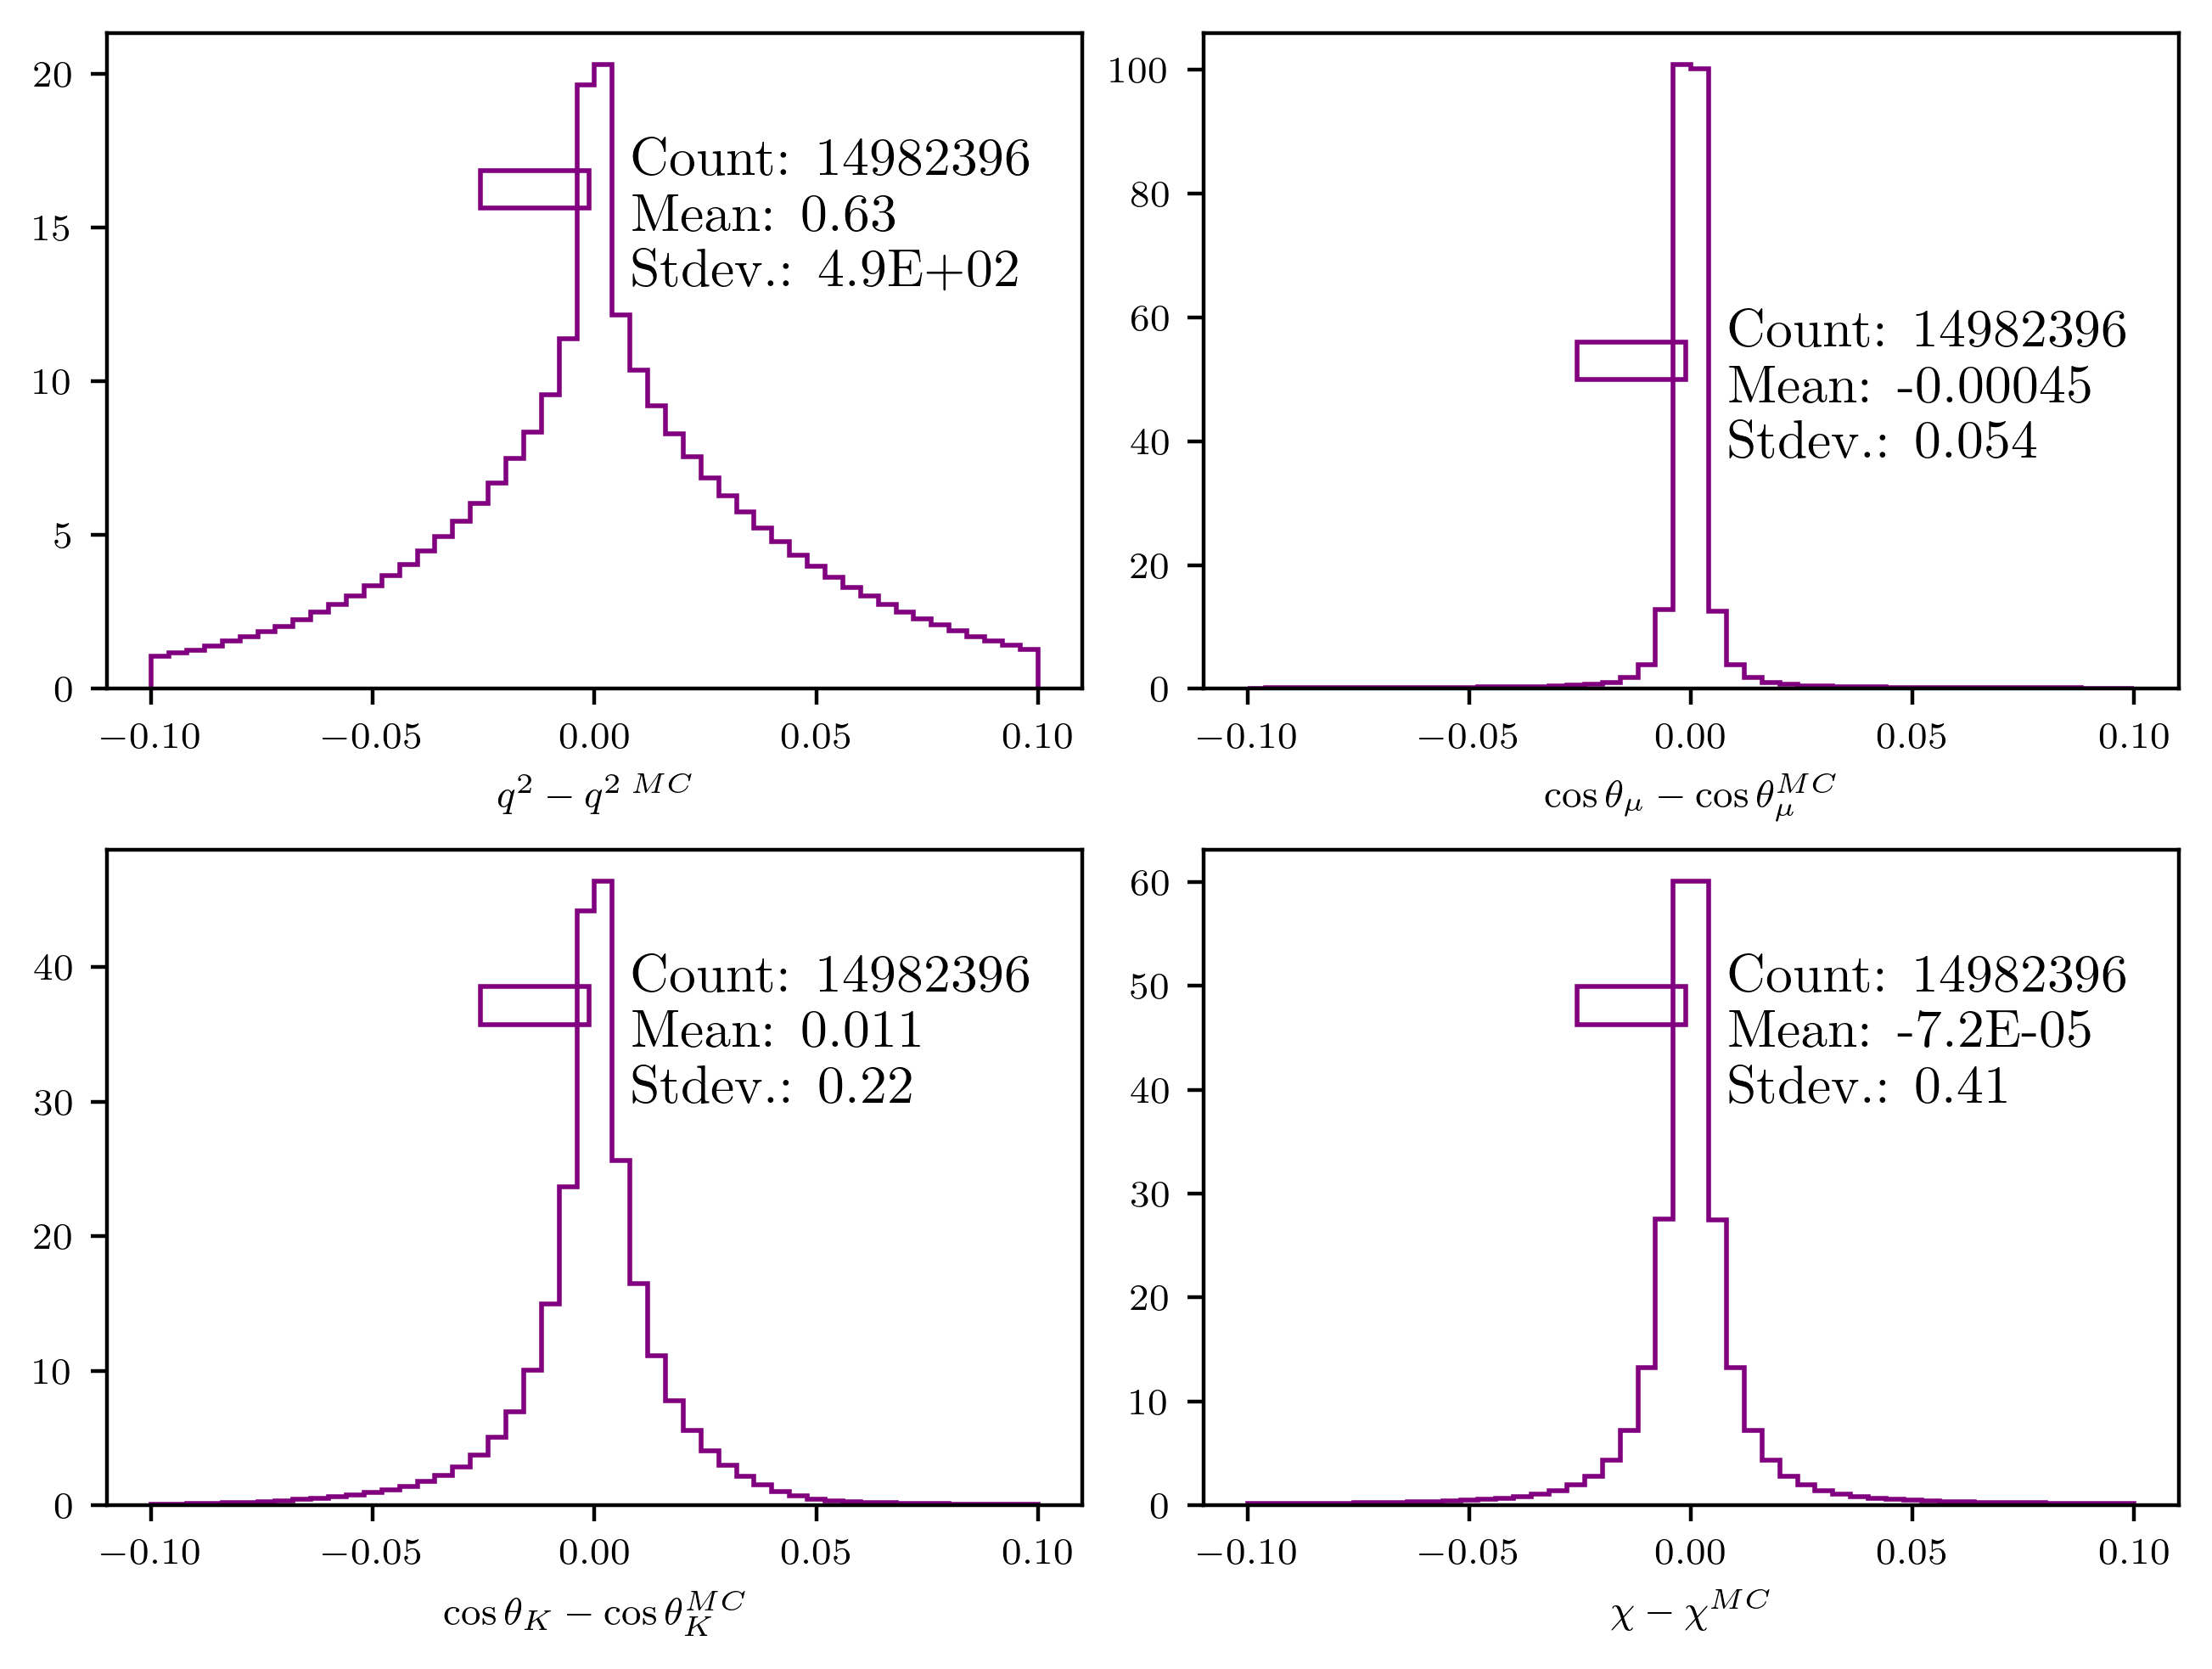

In [ ]:
fig, axs = plt.subplots(2,2, layout="compressed")

num_bins = 50

xlimits = {
    Names_of_Variables().q_squared : (-0.1, 0.1),
    Names_of_Variables().cos_theta_mu : (-0.1, 0.1),
    Names_of_Variables().cos_k : (-0.1, 0.1),
    Names_of_Variables().chi : (-0.1, 0.1)
}

xlabels = {
    Names_of_Variables().q_squared : r"$q^2 - q^{2\;MC}$",
    Names_of_Variables().cos_theta_mu : r"$\cos\theta_\mu - \cos\theta_\mu^{MC}$",
    Names_of_Variables().cos_k : r"$\cos\theta_K - \cos\theta_K^{MC}$",
    Names_of_Variables().chi : r"$\chi - \chi^{MC}$"
}

for ax, var in zip(axs.flat, Names_of_Variables().list_):

    ax.hist(
        resolutions[var],
        label=stats_legend(resolutions[var]),
        bins=num_bins,
        range=xlimits[var],  # does this cut out data?
        color="purple",
        histtype="step",
        density=True,
    )    

    ax.legend()

    ax.set_xlabel(xlabels[var])